# Thuật toán và Biểu diễn

In [1]:
from PriorityQueue import PriorityQueue
from Cell import Position, Cell

from typing import Iterable, Optional

def chebyshev_move(start: Position, end: Position) -> tuple[list[int], list[int]]:
    cur_x, cur_y = start
    xs = [cur_x]
    ys = [cur_y]

    while (cur_x != end.x) or (cur_y != end.y):
        dx = end.x - cur_x
        dy = end.y-cur_y
        if abs(dx) == abs(dy):
            # cur_x > end.x -> decrease x
            if dx < 0: cur_x -= 1
            else: cur_x += 1

            #cur_y > end.y -> decrease y
            if dy < 0: cur_y -= 1
            else: cur_y += 1
        elif abs(dx) < abs(dy):
            if dy < 0: cur_y -= 1
            elif dy > 0: cur_y += 1
        else:
            if dx < 0: cur_x -= 1
            elif dx > 0: cur_x += 1
        xs.append(cur_x)
        ys.append(cur_y)
    return xs, ys

def path_traceback(start_state: Cell, goal_state: Cell) -> list[Cell]:
    path = []
    while goal_state != start_state:
        path.append(goal_state)
        goal_state = goal_state.parent
    path.append(start_state)
    return list(reversed(path))

def astar_vacuum(dirty_cells: Iterable[Position],
                 start: Position, *,
                 do_traceback: bool = False)\
                -> tuple[Cell, Optional[list[Cell]]]:
    my_queue: PriorityQueue[Cell] = PriorityQueue()

    start_node = Cell(position=start, dirty_cells=dirty_cells)
    my_queue.push(start_node)
    while my_queue:
        cur = my_queue.pop()

        if len(cur.dirty_cells) == 0: break
        
        for neighbour in cur.expand_cell():
            if my_queue.get_attr(neighbour, 'cost', default_value=neighbour.cost + 1) > neighbour.cost:
                my_queue.push(neighbour)

    traceback = path_traceback(start_node, cur) if do_traceback else None
    return cur, traceback

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def show_animation(grid_dim:tuple[int, int], dirty_cells: set[Position],
                   xs: list[int], ys: list[int],
                   figure = plt.gcf()) -> None:
    figure.clear()
    ax = figure.add_subplot(xlim=(.5, grid_dim[1] + .5), ylim=(.5, grid_dim[0] + .5))
    ax_pos = ax.get_position()
    ax.set_aspect('equal')

    ax.vlines([i + .5 for i in range(0, grid_dim[1] + 1)],
              ymin=0, ymax=grid_dim[0] + 1, colors=(0, 0, 0, 0.2))
    ax.hlines([i + .5 for i in range(0, grid_dim[0] + 1)],
              xmin=0, xmax=grid_dim[1] + 1, colors=(0, 0, 0, 0.2))

    ax.set_xticks([i for i in range(1, grid_dim[1] + 1)])
    ax.set_yticks([i for i in range(1, grid_dim[0] + 1)])


    # path trace
    ax.plot(xs, ys, '--', color=(0, 0, 1, 0.2))
    robot, = ax.plot([], [], 's', color=(34 / 255, 139 / 255, 34 / 255))
    dirty, = ax.plot([cell.x for cell in dirty_cells],
                     [cell.y for cell in dirty_cells], 'X', color=(1, 0, 0, 0.5))

    figure.legend([robot, dirty], ['Robot', 'Dirty Cell'],
                  loc=(ax_pos.xmax - 0.13, ax_pos.ymax - 0.087))

    clean_costs = [1]
    cur_costs = [0]
    first = True
    for x, y in zip(xs[1:], ys[1:]):
        if (x, y) in dirty_cells and not first:
            first = True
            cur_costs.append(cur_costs[-1] + clean_costs[-1])
            clean_costs.append(clean_costs[-1])
        else:
            if (x, y) in dirty_cells: first = False
            clean_costs.append(clean_costs[-1] + 1)
            cur_costs.append(cur_costs[-1] + 1)
    
    cost_format = lambda clean, cur: f'Clean cost: {clean}\nCurrent cost: {cur}'
    cost_txt = figure.text(ax_pos.xmin - 0.1, ax_pos.ymax - 0.06,
                           cost_format(clean_costs[0], cur_costs[0]))
    first = True
    def animate(i):
        nonlocal dirty_cells, first
        
        if (xs[i], ys[i]) in dirty_cells and not first:
            dirty_cells = dirty_cells - {(xs[i], ys[i])}
            dirty.set_data([cell.x for cell in dirty_cells],
                           [cell.y for cell in dirty_cells])
            first = True
        elif (xs[i], ys[i]) in dirty_cells: first = False

        cost_txt.set_text(cost_format(clean_costs[i], cur_costs[i]))
        robot.set_data([xs[i]], [ys[i]])
        return robot, dirty


    ani = FuncAnimation(figure, animate, len(ys), interval=500, blit=True)
    return HTML(ani.to_jshtml())

<Figure size 640x480 with 0 Axes>

# <center>Chương trình<center>

In [3]:
import random as rand

In [3]:
dirty = {Position(1, 1),
         Position(1, 6),
         Position(3, 8),
         Position(5, 8),
         Position(8, 6)}
start = Position(4, 5)
grid_dim = (10, 8)
dirty_no = 10

In [ ]:
grid_dim = None
start = None
dirty_no = 0
dirty = set()
while not grid_dim or not start or not dirty_no:
    while not grid_dim:
        user_in = input("What is the grid dimension? (row, col): ")
        user_in = user_in.split(',')
        try:
            rows = int(user_in[0][1:])
            cols = int(user_in[1][:-1])
            grid_dim = (rows, cols)
        except ValueError:
            print("Incorrect format! Please specify number of rows and columns in grid as '(rows, cols)'")
    while not start:
        user_in = input("Where is the start position? Enter as (x, y) or any input to random a position: ")
        user_in = user_in.split(',')
        try:
            x = int(user_in[0][1:])
            y = int(user_in[1][:-1])
            if x < 1 or y < 1:
                print("Invalid input! Please specify start position in grid as '(x, y)' where x, y >= 1.\
                      Or any other input to random a position.")
                continue
            start = Position(x, y)
        except ValueError:
            start = Position(rand.randint(1, grid_dim[1]), rand.randint(1, grid_dim[0]))
    while not dirty_no:
        user_in = input("How many dirty cells are there? ")
        try:
            dirty_no = int(user_in)
            if dirty_no < 1: raise ValueError()
        except ValueError:
            print("Invalid input! Number of dirty cells must be integer >= 1")
            dirty_no = 0

positions = [Position(i, j) for i in range(1, grid_dim[1] + 1) for j in range(1, grid_dim[0] + 1)]
dirty = {pos for pos in rand.sample(positions, dirty_no)}

print(f"""Grid Dimension: {grid_dim[0]}x{grid_dim[1]}
Initial position: {start}
Positions of dirty cells:
{sorted(dirty)}""")

Grid Dimension: 10x10
Initial position: (6, 6)
Positions of dirty cells:
{(8, 8), (2, 1), (8, 1), (7, 10), (5, 4), (6, 8), (2, 2), (8, 2), (1, 3)}


In [4]:
goal = astar_vacuum(dirty, start, do_traceback=True)
print(f"Total cost: {goal[0].cost}")

Total cost: 64


In [5]:
for i, cell in enumerate(goal[1]):
    action = 'Start at' if i == 0 else 'Suck'
    print(f"{action} cell {cell.position} with cost {cell.cost}")

Start at cell (4, 5) with cost 0
Suck cell (1, 6) with cost 7
Suck cell (3, 8) with cost 15
Suck cell (5, 8) with cost 25
Suck cell (8, 6) with cost 39
Suck cell (1, 1) with cost 64


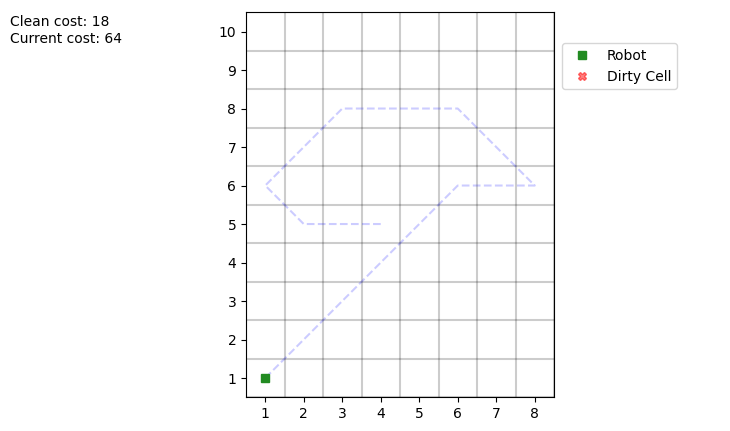

In [7]:
xs = []
ys = []
for i, cell in enumerate(goal[1][:-1]):
    temp_x, temp_y = chebyshev_move(cell.position, goal[1][i + 1].position)
    xs.extend(temp_x)
    ys.extend(temp_y)
xs.append(goal[0].position.x)
ys.append(goal[0].position.y)
fig = plt.figure(figsize=(8, 5))
show_animation(grid_dim, dirty, xs, ys, fig)